In [ ]:
# 할당된 GPU 실행
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
  try:
    # GPU 메모리 사용 설정
    tf.config.experimental.set_memory_growth(gpus[0], True)  
  except RuntimeError as re:
    print(re)

# GPU 메모리를 전부 할당하지 않고 필요에 따라 자동으로 할당하도록 설정
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Yolo개념

- CNN의 치명적인 단점  
  이미지 자체만 인식할 수 있음(이미지 내 객체를 감지하는 것은 못함)
- Yolo는 객체탐지 가능 -> 어떤 영역에 어떤 객체가 있는지 탐지 가능(영상에서도 객체인식이 가능)  

- 객체 탐지 알고리즘의 역사  
  1) Traditional Detection Methods  
    슬라이딩 윈도우 : 고정된 크기의 윈도우로 이미지의 좌상단부터 우하단으로 일일이 객체를 검출해가나가는 방식(객체탐지를 잘함)
    문제점 : 객체가 없는 모든 영역을 스캔해야하기 때문에 수행시간 오래 걸림, 인접영역에서 중복탐지를 함  
  2) Two-stage detector(1초에 5\~10장 탐지)
    영역추정과 탐지 두단계로 수행, R-CNN알고리즘에서는 객체가 있을 법한 위치를 추정하고 그 영역에 대해서만 객체탐지하는 두단계 제안
    영역추정의 문제점 : 객체들이 각기 다른 크기와 형태를 가지고 있다면 후보 영역을 찾는 정확도가 떨어지게 됨 -> 정확도 향상시키기 위해 미리 이미지에서 객체영역을 분할해 두면 후보 영역을 찾기가 더 쉽지 않을까?
    선택적 검색 : 처음 불할된 모든 부분들을 바운딩박스로 만들어 리스트에 추가, 색상, 무늬, 크기 형태에 따라 유사도가 비슷한 부분들을 그룹핑(박스 개수 감소), 앞의 과정 반복(여전히 실시간 적용 어려움)  
  3) One-stage detector(1초에 50~70장 탐지)   
    영억추정과 객체탐지를 통합해 한 번에 수행, 가장 큰 장점은 탐지 속도의 획기적인 향상으로 실시간 탐지 가능
    문제점 : Two-stage detector보다 정확도가 조금 더 낮음(근데 속도 넘사)

- Yolo v1은 Two-stage detector의 Faster R-CNN보다 6배 빠른 One-stage detector


# roboflow
- 데이터 준비
- 준비된 데이터 코랩에서 다운 받아서 사용하게될 것

In [ ]:
# robofow의 데이터 가져오기
!curl -L "https://app.roboflow.com/ds/T3VPsr5dIo?key=gwVAuCCgwE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   1256      0 --:--:-- --:--:-- --:--:--  1254
100 10.6M  100 10.6M    0     0  5258k      0  0:00:02  0:00:02 --:--:--  271M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/cat-16_jpg.rf.63b33bcafeceb187104961397bc8dbd3.jpg  
 extracting: test/images/cat-31_jpg.rf.82ab9b7b47169b6b7ffd99e216fd27b9.jpg  
 extracting: test/images/cat-32_jpg.rf.32eecc62e181b966d35c879f9a277d2f.jpg  
 extracting: test/images/cat-40_jpg.rf.8a9611bae0bd4287a737e44a3dacf687.jpg  
 extracting: test/images/cat-80_jpg.rf.03c56d09144a451944fad60d84a74470.jpg  
 extracting: test/images/cat-97_jpg.rf.c8d8e91c296c80025efa2f2a0c7e4bad.jpg  
 extracting: test/images/dog-20_jp

# Yolo v5
- train.py : 학습할 때 사용할 파이썬 파일
- detect.py : 학습시키고 나서 검출할 때 사용하는 파이썬 파일
- requirement.txt : yolo사용하기위해 필요한 라이브러리 모여 있는 파일

In [ ]:
%pwd # print working directory (현재 사용하고 있는 디렉토리 알려줘)

'/content'

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14411, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 14411 (delta 12), reused 22 (delta 10), pack-reused 14379
Receiving objects: 100% (14411/14411), 13.37 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (9967/9967), done.


In [ ]:
# yolo를 사용하는데 필요한 라이브러리 설치하기
# change directory : cd
%cd /content/yolov5
!pip install -r requirements.txt

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 36.8 MB/s 


In [ ]:
%pwd

'/content/yolov5'

In [ ]:
%cd ../  
%pwd

/content


'/content'

In [ ]:
# 데이터셋 정리
# make directory : mkdir
%mkdir dataset
# 폴더와 파일의 위치 변경
# move : mv 앞에 적은 경로에 있는 것(들)을 -> 마지막에 적은 경로에 옮김 (띄어쓰기로 구분)
%mv ./README.dataset.txt ./README.roboflow.txt ./data.yaml train test valid /content/dataset 

In [ ]:
# 파일 내용 보기
# concatenate  : cat
%cat /content/dataset/data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['cat', 'dog']

In [ ]:
# 파일의 모든 경로가 담긴 txt파일 만들기
from glob import glob   # 많은 파일들을 다룰때 사용하는 라이브러리
train_img_list = glob('/content/dataset/train/images/*.jpg')
test_img_list = glob('/content/dataset/test/images/*.jpg')
valid_img_list = glob('/content/dataset/valid/images/*.jpg')
len(valid_img_list)

38

In [ ]:
# 모든 이미지 경로를 하나의 파일에 담아줌
# train.txt, val.txt 파일에 각각 담아줌
with open('/content/dataset/train.txt', 'w') as f:  # open : 파일을 열고, w : write 쓰기모드
  f.write('\n'.join(train_img_list) + '\n')  # write : txt파일에 적을거다 리스트에 있는 내용을 하나입력하고 엔터 반복하겠다
with open('/content/dataset/val.txt', 'w') as f:
  f.write('\n'.join(valid_img_list) + '\n')

In [ ]:
# data.yaml 파일 불러와서 수정
import yaml

with open('/content/dataset/data.yaml','r') as f:  # r : 읽어만 올거야 그걸 f라고 부를게
  data = yaml.safe_load(f)   # 데이터라는 변수안에 읽은거 담아줄게 (이 변수에 담긴거 수정)

print(data)   # 딕셔너리 파일로 담겨있음

{'train': '../train/images', 'val': '../valid/images', 'nc': 2, 'names': ['cat', 'dog']}


In [ ]:
data['train'] = '/content/dataset/train.txt' # 딕셔너리니까 key값으로 접근
data['val'] = '/content/dataset/val.txt'
data   # 값이 바뀌었는지 확인

{'train': '/content/dataset/train.txt',
 'val': '/content/dataset/val.txt',
 'nc': 2,
 'names': ['cat', 'dog']}

In [ ]:
#data변수에 담긴 걸 yaml파일에 덮어씌워주기
with open('/content/dataset/data.yaml', 'w') as f:
  # dump(이변수에 있는 값을, 여기에 건내준다)) : 건네주다
  yaml.dump(data, f)

In [ ]:
%pwd

'/content'

In [ ]:
# 학습 모듈이 있는 dir로 이동
%cd /content/yolov5

/content/yolov5


In [ ]:
# 학습 모듈 실행
!python train.py --img 416 --batch 16 --epochs 20 --data /content/dataset/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name cat_dog_yolov5s_results

train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=cat_dog_yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-205-geef9057 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_

In [ ]:
test_img = test_img_list[0]

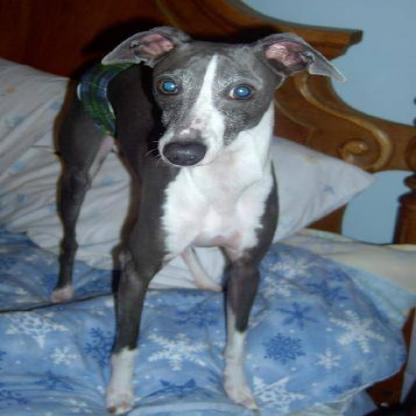

In [ ]:
from IPython.display import Image
Image(test_img)

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/cat_dog_yolov5s_results/weights/best.pt --img 416 --conf 0.06 --source "{test_img}"

detect: weights=['/content/yolov5/runs/train/cat_dog_yolov5s_results/weights/best.pt'], source=/content/dataset/test/images/dog-84_jpg.rf.5fc6d0ce405ccda69036327a320dbc31.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.06, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-205-geef9057 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/dataset/test/images/dog-84_jpg.rf.5fc6d0ce405ccda69036327a320dbc31.jpg: 416x416 1 dog, 8.2ms
Speed: 0.4ms pre-process, 8.2ms inference, 1.6ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp


In [ ]:
# 실행의 결과를 변수에 담음
rs = !python detect.py --weights /content/yolov5/runs/train/cat_dog_yolov5s_results/weights/best.pt --img 416 --conf 0.06 --source "{test_img}"

In [ ]:
rs

["\x1b\x1bdetect: \x1bweights=['/content/yolov5/runs/train/cat_dog_yolov5s_results/weights/best.pt'], source=/content/dataset/test/images/dog-84_jpg.rf.5fc6d0ce405ccda69036327a320dbc31.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.06, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1",
 'YOLOv5 🚀 v6.2-205-geef9057 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)',
 '',
 'Fusing layers... ',
 'YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs',
 "[tensor(31., device='cuda:0'), tensor(8., device='cuda:0'), tensor(383., device='cuda:0'), tensor(216., device='cuda:0')]",
 'dog',
 "tensor(0.52204, device='cuda:0')",
 'image 1/1 /content/dataset/test/images/dog-

In [ ]:
len(test_img_list)

20